# Data Vault Demo (Dev -- Full Access)

The basic concept of the Data Vault is that when a user authenticates, they receive an engine that gives them access to all the data (rows, columns, tables, schema, etc.) for which they are authorized.  Users who can authenticate themselves for multiple roles can use those roles simultaneously.  We are keeping in mind the importance of Data Lineage Management (tracked by issue https://github.com/os-climate/os_c_data_commons/issues/50) but is not treated as part of this particular prototype.

The steps of this demo are:

1. **Authenticate and acquire SQLAlchemy engine**
    1. **Dev engine sees all**
    2. Quant engine can do temp scoring but not see fundamental company info
    3. User engine can use temp scoring but not see cumulative emissions nor overshoot info
2. **With Dev engine, construct Vaults for:**
    1. Fundamental corporate financial information
    2. Corporate emissions data (base year, historical)
    3. Corporate target data (start year, end year, target start value, target end value)
    4. Sector benchmark data (production, CO2e intensity)
3. **Dev Engine: Visualize projected emissions (targets and trajectories) and calculate cumulative emissions**
4. Quant Engine (vault_demo_n1): Using calculated cumulative emmisions, visualize per-company trajectory and target temperature scores
5. User Engine (value_demo_n2): Using consensus probability scoring and own portfolio data (ISIN, position value)
    1. Calculate publishable per-company temperature alignment score
    2. Based on aggregate corporate and portfolio information, produce weighting scores to yield overall portfolio alignment score

In [1]:
import os
import osc_ingest_trino as osc

import json
import pandas as pd

from ITR.data.osc_units import ureg
from ITR.data.vault_providers import (
    VaultCompanyDataProvider,
    VaultProviderProductionBenchmark,
    VaultProviderIntensityBenchmark,
    DataVaultWarehouse,
    requantify_df,
)

# from ITR.interfaces import ICompanyData, EScope, ETimeFrames, PortfolioCompany, IEIBenchmarkScopes, \
#     IProductionBenchmarkScopes
from ITR.interfaces import IProductionBenchmarkScopes, IEIBenchmarkScopes

ingest_catalog = "osc_datacommons_dev"
ingest_schema = "demo_dv"
itr_prefix = "itr_"

osc.load_credentials_dotenv()

In [2]:
# bucket must be configured with credentials for trino, and accessible to the hive catalog
# You may need to use a different prefix here depending on how you name your credentials.env variables
hive_bucket = osc.attach_s3_bucket("S3_OSCCL2")

hive_catalog = "osc_datacommons_hive_ingest"
hive_schema = "ingest"

### Step 1: Initialize Vault user 'Dev', which has full visibility into corporate financial, production, and target data

In [3]:
engine_dev = osc.attach_trino_engine(
    verbose=True, catalog=ingest_catalog, schema=ingest_schema
)
qres = osc._do_sql(f"show tables in {ingest_schema}", engine_dev, verbose=True)

# Check that we have the tables we need
required_tables = ["company_data", "target_data", "trajectory_data", "emissions_data"]
existing_tables = [q[0] for q in qres]
missing_tables = [
    rtable
    for rtable in required_tables
    if f"{itr_prefix}{rtable}" not in existing_tables
]
if missing_tables:
    print(f"Missing tables (itr_prefix = {itr_prefix}): {missing_tables}")
    assert False

using connect string: trino://MichaelTiemannOSC@trino-secure-odh-trino.apps.odh-cl2.apps.os-climate.org:443/osc_datacommons_dev/demo_dv
show tables in demo_dv
[('itr_company_data',), ('itr_emissions_data',), ('itr_production_data',), ('itr_target_data',), ('itr_trajectory_data',)]


### The ITR module provides Vault objects that coordinate the interaction of Dev, Quant, and User roles.

The SQLAlchemy engines mediate the actual interaction with the Data Vault.

### Step 2: construct vaults for corporate financial, production, and target information.

We also create benchmark data (which is presumed public information).  There's more work to be done to modularly add new benchmarks that automatically become available options to to the ITR tool.

In this demo we read ITR benchmark data from JSON files (REST API-friendly).  Such data coming from the notebook filesystem is "untethered" data.  The corporate data comes from an existing data pipeline (in this case, the pipeline processing RMI data).  When data comes from the data commons, it is "tethered" to the Data Commons.  The Data Vault can only control access to data that goes through the Data Commons via 'engines'.

In [4]:
from ITR import data_dir as json_data_dir

benchmark_prod_json = os.path.join(json_data_dir, "benchmark_production_OECM.json")
benchmark_EI_json = os.path.join(json_data_dir, "benchmark_EI_OECM_S3.json")

# load production benchmarks
with open(benchmark_prod_json) as json_file:
    parsed_json = json.load(json_file)
prod_bms = IProductionBenchmarkScopes.model_validate(parsed_json)
vault_production_bm = VaultProviderProductionBenchmark(
    engine=engine_dev,
    benchmark_name=f"{itr_prefix}benchmark_prod",
    production_benchmarks=prod_bms,
    hive_bucket=hive_bucket,
    hive_catalog=hive_catalog,
    hive_schema=hive_schema,
)

# load intensity benchmarks
with open(benchmark_EI_json) as json_file:
    parsed_json = json.load(json_file)
ei_bms = IEIBenchmarkScopes.model_validate(parsed_json)
vault_EI_bm = VaultProviderIntensityBenchmark(
    engine=engine_dev,
    benchmark_name=f"{itr_prefix}benchmark_ei",
    EI_benchmarks=ei_bms,
    hive_bucket=hive_bucket,
    hive_catalog=hive_catalog,
    hive_schema=hive_schema,
)

# load company data
# TODO: Pandas reads null data mixed with integers as float64 (np.nan).  This can be fixed post hoc with astype('Int16')
vault_company_data = VaultCompanyDataProvider(
    engine=engine_dev, company_table=f"{itr_prefix}company_data"
)

vault_warehouse = DataVaultWarehouse(
    engine_dev,
    vault_company_data,
    vault_production_bm,
    vault_EI_bm,
    itr_prefix=itr_prefix,
)

/Users/michael/virtualenvs/itr-examples/lib/python3.11/site-packages/pandas/core/dtypes/missing.py:225: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return _isna_array(np.asarray(obj), inf_as_na=inf_as_na)
/Users/michael/virtualenvs/itr-examples/lib/python3.11/site-packages/pandas/core/dtypes/missing.py:225: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return _isna_array(np.asarray(obj), inf_as_na=inf_as_na)
2023-12-01 15:17:39,092 - ITR.data.data_warehouse - INFO - new_production_bm calculating trajectories for 0companies (times 5 scopes times 31 years)
2023-12-01 15:17:39,093 - ITR.data.base_providers - INFO - Normalizing intensity metrics
2023-12-01 15:17:39,093 - ITR.data.base_providers - INFO - Done normalizing intensity metrics
2023-12-01 15:17:39,094 - ITR.data.data_warehouse - INFO - projecting targets for 0 companies (times 5 scopes times 31 years)


create table demo_dv.itr_cumulative_emissions with (format = 'ORC', partitioning = array['scope']) as 
select C.company_name, C.company_id, 'demo_dv' as source, P.year,
       sum(EI.ei_s1_by_year * P.production_by_year) over (partition by C.company_id order by P.year) as cumulative_trajectory,
       concat(EI.ei_s1_by_year_units, ' * ', P.production_by_year_units) as cumulative_trajectory_units,
       sum(ET.ei_s1_by_year * P.production_by_year) over (partition by C.company_id order by P.year) as cumulative_target,
       concat(ET.ei_s1_by_year_units, ' * ', P.production_by_year_units) as cumulative_target_units,
       'S1' as scope
from 
    demo_dv.itr_company_data C
         join demo_dv.itr_production_data P on P.company_id=C.company_id
         join demo_dv.itr_trajectory_data EI on EI.company_id=C.company_id and EI.year=P.year and EI.ei_s1_by_year is not NULL
         join demo_dv.itr_target_data ET on ET.company_id=C.company_id and ET.year=P.year and ET.ei_s1_by_year is not

### Step 3: Visualize Emissions, Targets, and Trajectories

SuperSet Dashboard here (not really, not yet, but points to TRINO_USER dashboard, not TRINO_USER1 dashboard): https://superset-secure-odh-superset.apps.odh-cl2.apps.os-climate.org/superset/dashboard/4/?edit=true&native_filters=%28%29

Plot emissions data.  Others can be plotted by following same pattern.

Note that without units, a company that emits 80 t CO2e/t Steel looks like it might emit a lot more than one that emits 10t CO2e/MWh.  With units, it becomes clear that the 80 and the 10 are not comparable.

In [5]:
sql_df = pd.read_sql_table(f"{itr_prefix}emissions_data", engine_dev)
sql_df

/Users/michael/virtualenvs/itr-examples/lib/python3.11/site-packages/pandas/io/sql.py:1665: SAWarning: index key 'partition' was not located in columns for table 'itr_emissions_data'
  self.meta.reflect(bind=self.con, only=[table_name], views=True)
/Users/michael/virtualenvs/itr-examples/lib/python3.11/site-packages/pandas/io/sql.py:1665: SAWarning: index key 'record_count' was not located in columns for table 'itr_emissions_data'
  self.meta.reflect(bind=self.con, only=[table_name], views=True)
/Users/michael/virtualenvs/itr-examples/lib/python3.11/site-packages/pandas/io/sql.py:1665: SAWarning: index key 'file_count' was not located in columns for table 'itr_emissions_data'
  self.meta.reflect(bind=self.con, only=[table_name], views=True)
/Users/michael/virtualenvs/itr-examples/lib/python3.11/site-packages/pandas/io/sql.py:1665: SAWarning: index key 'total_size' was not located in columns for table 'itr_emissions_data'
  self.meta.reflect(bind=self.con, only=[table_name], views=True)

,company_name,company_lei,company_id,sector,co2_s1_by_year,co2_s1_by_year_units,co2_s2_by_year,co2_s2_by_year_units,co2_s3_by_year,co2_s3_by_year_units,co2_s1s2_by_year,co2_s1s2_by_year_units,co2_s1s2s3_by_year,co2_s1s2s3_by_year_units,year
0,SK Innovation,988400PXP70BWVSJVF07,096770.SK,Energy,2.663869,CO2e * megametric_ton,0.743441,CO2e * megametric_ton,102.387927,CO2e * megametric_ton,4.840313,CO2e * megametric_ton,107.228239,CO2e * megametric_ton,2033
1,Saudi Aramco,5586006WD91QHB7J4X50,2222.SR,Energy,NaN,CO2e * megametric_ton,NaN,CO2e * megametric_ton,NaN,CO2e * megametric_ton,39.727289,CO2e * megametric_ton,NaN,CO2e * megametric_ton,2033
2,Tokyo Electric Power Company,5299004EMJ3R4RVR5Y75,9501.T,Electricity Utilities,0.109342,CO2e * megametric_ton,3.478445,CO2e * megametric_ton,NaN,CO2e * megametric_ton,3.587787,CO2e * megametric_ton,NaN,CO2e * megametric_ton,2033
3,Verbund AG,5299006UDSEJCTTEJS30,AT0000746409,Electricity Utilities,0.222178,CO2e * megametric_ton,0.124792,CO2e * megametric_ton,NaN,CO2e * megametric_ton,0.346970,CO2e * megametric_ton,NaN,CO2e * megametric_ton,2033
4,PETROLEO BRASILEIRO S A PETROBRAS,5493000J801JZRCMFE49,BRPETRACNPR6,Energy,23.807398,CO2e * megametric_ton,0.155097,CO2e * megametric_ton,0.378485,CO2e * megametric_ton,38.810060,CO2e * megametric_ton,39.188545,CO2e * megametric_ton,2033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,UNITED STATES STEEL CORP,JNLUVFYJT1OZSIQ24U47,US9129091081,Steel,NaN,CO2e * megametric_ton,NaN,CO2e * megametric_ton,NaN,CO2e * megametric_ton,32.135033,CO2e * megametric_ton,NaN,CO2e * megametric_ton,2020
2396,Vistra Corp.,549300KP43CPCUJOOG15,US92840M1027,Electricity Utilities,104.800415,CO2e * megametric_ton,0.370975,CO2e * megametric_ton,NaN,CO2e * megametric_ton,94.623793,CO2e * megametric_ton,NaN,CO2e * megametric_ton,2020
2397,WEC Energy Group,549300IGLYTZUK3PVP70,US92939U1060,Electricity Utilities,9.932947,CO2e * megametric_ton,0.000000,CO2e * megametric_ton,NaN,CO2e * megametric_ton,9.932947,CO2e * megametric_ton,NaN,CO2e * megametric_ton,2020
2398,WORTHINGTON INDUSTRIES INC,1WRCIANKYOIK6KYE5E82,US9818111026,Steel,0.127534,CO2e * megametric_ton,0.136031,CO2e * megametric_ton,NaN,CO2e * megametric_ton,0.263566,CO2e * megametric_ton,NaN,CO2e * megametric_ton,2020


In [6]:
df = requantify_df(
    sql_df.dropna(),
    typemap={
        "co2_s1_by_year": "Mt CO2",
        "co2_s2_by_year": "Mt CO2",
        "co2_s3_by_year": "Mt CO2",
    },
).convert_dtypes()
df = df[
    df.company_id.ne("US6362744095+Gas Utilities")
    & df.company_id.ne("US0236081024+Gas Utilities")
]
df = df[df.co2_s1_by_year.gt(ureg("10.0 Mt CO2e"))]

In [7]:
df.dtypes

company_name                       string[python]
company_lei                        string[python]
company_id                         string[python]
sector                             string[python]
co2_s1_by_year         pint[CO2 * megametric_ton]
co2_s2_by_year         pint[CO2 * megametric_ton]
co2_s3_by_year         pint[CO2 * megametric_ton]
co2_s1s2_by_year      pint[CO2e * megametric_ton]
co2_s1s2s3_by_year    pint[CO2e * megametric_ton]
year                                        Int64
dtype: object

In [8]:
df = df.sort_values(["company_name", "year"]).reset_index(drop=True)

In [9]:
df

,company_name,company_lei,company_id,sector,co2_s1_by_year,co2_s2_by_year,co2_s3_by_year,co2_s1s2_by_year,co2_s1s2s3_by_year,year
0,AES Corp.,2NUNNB7D43COUIRE5295,US00130H1059,Electricity Utilities,47.3515,0.3415,9.9732,47.693,57.66619999999999,2019
1,AES Corp.,2NUNNB7D43COUIRE5295,US00130H1059,Electricity Utilities,44.01133075304652,0.26020991157733336,7.446920823771463,44.27154066462386,50.484199999999994,2020
2,AES Corp.,2NUNNB7D43COUIRE5295,US00130H1059,Electricity Utilities,44.998347629189425,0.2766385857201917,8.028285429627031,45.274986214909624,48.806732,2021
3,AES Corp.,2NUNNB7D43COUIRE5295,US00130H1059,Electricity Utilities,40.48978535574408,0.24892107259648147,7.561792154712528,41.3943014892072,44.766537699240125,2022
4,AES Corp.,2NUNNB7D43COUIRE5295,US00130H1059,Electricity Utilities,36.37837549508646,0.22364515316626252,7.118136290231733,37.84624445043138,41.03617904451506,2023
...,...,...,...,...,...,...,...,...,...,...
77,Sinopec,2138009UNXTD8EYS5M35,CN0005789556,Energy,20.13387743903819,3.281016016147347,0.06709100309900219,25.939372655661934,26.00646365876094,2039
78,Sinopec,2138009UNXTD8EYS5M35,CN0005789556,Energy,17.526235705127213,2.856074803544791,0.05819967836922532,22.50172267407126,22.559922352440488,2040
79,Sinopec,2138009UNXTD8EYS5M35,CN0005789556,Energy,15.128592267076751,2.4653549064423497,0.050070199459775026,19.358624893622192,19.408695093081967,2041
80,Sinopec,2138009UNXTD8EYS5M35,CN0005789556,Energy,12.908156572051656,2.103512777410764,0.042584151453269346,16.46429659341209,16.50688074486536,2042


<Axes: xlabel='year', ylabel='CO2·megametric_ton'>

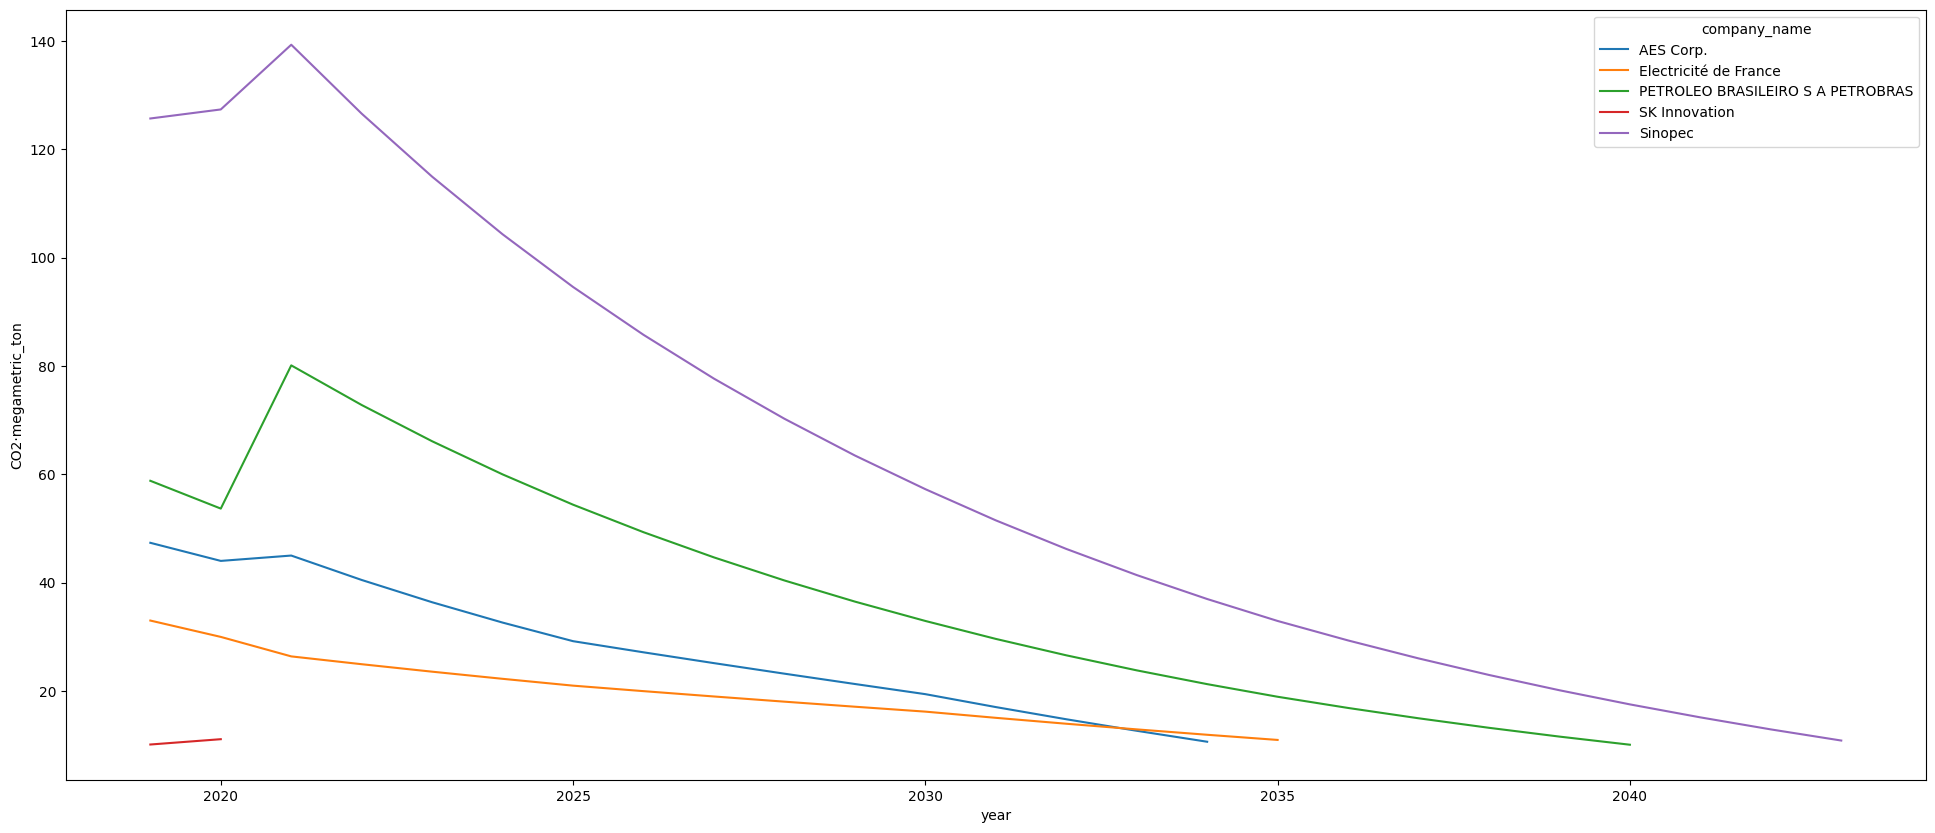

In [10]:
ureg.setup_matplotlib(True)
plottable_df = df.pivot(
    index="year", columns="company_name", values="co2_s1_by_year"
).reset_index()
# Must plot the first few columns, but then plot 1/3rd of the companies so as not to over-clutter the graph
plottable_df.plot(x="year", kind="line", figsize=(24, 10))

## From this point forward, this is just a sketch...

While we could technically instantiate Quant and User engines and demonstrate the access restrictions particular to those personna, it's not really "right" to demonstrate restrictions via the database that can still be accessed via the python namespace.  So we actually put the following code into separate notebooks which cannot access the data in dataframes above.

### Step 4: Use Quant engine to access and visualize temperature scores

When the Data Vault is ready to be implemented, we can demonstrate that the Quant engine does not have access to primary company data (neither financial nor production)

Show that we *cannot* access fundamental company data (cannot show until op1st team changes permissions)

Show that we *can* access both cumulative emissions (input) and temperature scores (output)

### Step 5: Show per-company temperature score and weighted portfolio alignment score

Portfolio weighting scores (which ultimately influence portfolio alignment score) include:
* WATS (size of portfolio company positions used as weights)
* TETS (size of total emissions of portfolio companies used as weights)
* Financial fundamental weights:
    * Market Cap
    * Enterprise Value
    * Assets
    * Revenues

We can pass a list of company IDs to the Data Vault to get back a sum without exposing granular data

Show that we *cannot* access fundamental company data (cannot show until op1st team changes permissions)

Show that we *can* access both cumulative emissions (input) and temperature scores (output)

### Calculate portfolio alignment temperature score based on WATS

We can do this with information exclusive to the user space (and the probability-adjusted temperature scores)

Note that companies with no production information (such as TITAL INTERNATIONAL INC and UNIVERSAL STAINLESS & ALLOY PRODUCTS INC will show NaN (Not a Number) as a score.

### Calculate portfolio alignment temperature score based on TETS

We need to carefully meld portfolio data with corp fundamental data (in this case, emissions)

### Calculate portfolio alignment temperature score based on MOTS, EOTS, ECOTS, AOTS, and ROTS

* MOTS = market cap weights
* EOTS = enterprise value weights
* ECOTS = EVIC weights
* AOTS = asset weights
* ROTS = revenue weights

### Companies for which we lack production data (and thus cannot chart)